In [17]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [34]:
DIR_SYMBOLS = './symbols_1'
DIR_IMAGES = './img'
DIR_TMP = './tmp'
DEFAULT_TEMPLATE_MATCHING_THRESHOLD = 0.8
THR = 160

In [10]:
# Template Class
class Template:
    def __init__(
        self,
        image_path,
        label,
        color,
        matching_threshold=DEFAULT_TEMPLATE_MATCHING_THRESHOLD
    ):
        self.image_path = image_path
        self.label = label
        self.color = color
        self.template = cv2.imread(image_path)
        self.template_height, self.template_width = self.template.shape[:2]
        self.matching_threshold = matching_threshold

In [16]:
# Read all symbol images
symbols_templates = []
for ifile in os.listdir(DIR_SYMBOLS):
    if ifile.endswith(".png"):
        path = os.path.join(DIR_SYMBOLS, ifile)
        label, _ = os.path.splitext(ifile)
        t_ = Template(
            image_path=path,
            label=label,
            color=(0,0,255)
        )
        symbols_templates.append(t_)

In [24]:
s_d = {s_.label: s_ for s_ in (symbols_templates)}
s_ = sorted(s_d.keys())

In [32]:
@interact(symbol=s_)
def show_symbol(symbol):
    print(f"Label = {symbol}")
    template = s_d[symbol].template
    print(f"Dim = {template.shape[1]} x {template.shape[0]}")
    plt.imshow(template)
    plt.show()


interactive(children=(Dropdown(description='symbol', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'…

In [129]:
# TEST = 'captcha_78.png'
# TEST = 'captcha_83.png'
TEST = 'captcha_19.png'
filename, extension = os.path.splitext(TEST)
test_path = os.path.join(DIR_IMAGES, TEST)

In [130]:
img = cv2.imread(test_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_inv = cv2.bitwise_not(gray)
_, img_thr = cv2.threshold(gray_inv, THR, 255, cv2.THRESH_BINARY)
test_file = filename + '_bw' + extension
out_path = os.path.join(DIR_TMP, test_file)
cv2.imwrite(out_path, img_thr)

True

In [131]:
img_ = cv2.imread(out_path)

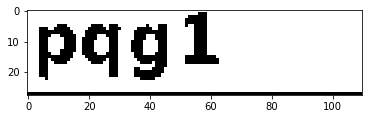

In [132]:
plt.imshow(img_)
plt.show()

In [133]:
detections = []
for template in symbols_templates:
    template_matching = cv2.matchTemplate(
        template.template, img_, cv2.TM_CCOEFF_NORMED
    )
    match_locations = np.where(template_matching >= template.matching_threshold)
    for (x, y) in zip(match_locations[1], match_locations[0]):
        match = {
            "TOP_LEFT_X": x,
            "TOP_LEFT_Y": y,
            "BOTTOM_RIGHT_X": x + template.template_width,
            "BOTTOM_RIGHT_Y": y + template.template_height,
            "MATCH_VALUE": template_matching[y, x],
            "LABEL": template.label,
            "COLOR": template.color
        }
        
        detections.append(match)

In [134]:
detections

[{'TOP_LEFT_X': 51,
  'TOP_LEFT_Y': 0,
  'BOTTOM_RIGHT_X': 64,
  'BOTTOM_RIGHT_Y': 27,
  'MATCH_VALUE': 0.97123766,
  'LABEL': '1',
  'COLOR': (0, 0, 255)},
 {'TOP_LEFT_X': 17,
  'TOP_LEFT_Y': 0,
  'BOTTOM_RIGHT_X': 31,
  'BOTTOM_RIGHT_Y': 27,
  'MATCH_VALUE': 0.8285608,
  'LABEL': 'g',
  'COLOR': (0, 0, 255)},
 {'TOP_LEFT_X': 33,
  'TOP_LEFT_Y': 0,
  'BOTTOM_RIGHT_X': 47,
  'BOTTOM_RIGHT_Y': 27,
  'MATCH_VALUE': 0.93714714,
  'LABEL': 'g',
  'COLOR': (0, 0, 255)},
 {'TOP_LEFT_X': 3,
  'TOP_LEFT_Y': 0,
  'BOTTOM_RIGHT_X': 17,
  'BOTTOM_RIGHT_Y': 27,
  'MATCH_VALUE': 0.84165895,
  'LABEL': 'p',
  'COLOR': (0, 0, 255)},
 {'TOP_LEFT_X': 17,
  'TOP_LEFT_Y': 0,
  'BOTTOM_RIGHT_X': 32,
  'BOTTOM_RIGHT_Y': 27,
  'MATCH_VALUE': 0.8804124,
  'LABEL': 'q',
  'COLOR': (0, 0, 255)}]

In [135]:
# Sort detections by Match Value
detections_ = sorted(detections, key=lambda obj: obj['TOP_LEFT_X'], reverse=False)

In [136]:
detections_

[{'TOP_LEFT_X': 3,
  'TOP_LEFT_Y': 0,
  'BOTTOM_RIGHT_X': 17,
  'BOTTOM_RIGHT_Y': 27,
  'MATCH_VALUE': 0.84165895,
  'LABEL': 'p',
  'COLOR': (0, 0, 255)},
 {'TOP_LEFT_X': 17,
  'TOP_LEFT_Y': 0,
  'BOTTOM_RIGHT_X': 31,
  'BOTTOM_RIGHT_Y': 27,
  'MATCH_VALUE': 0.8285608,
  'LABEL': 'g',
  'COLOR': (0, 0, 255)},
 {'TOP_LEFT_X': 17,
  'TOP_LEFT_Y': 0,
  'BOTTOM_RIGHT_X': 32,
  'BOTTOM_RIGHT_Y': 27,
  'MATCH_VALUE': 0.8804124,
  'LABEL': 'q',
  'COLOR': (0, 0, 255)},
 {'TOP_LEFT_X': 33,
  'TOP_LEFT_Y': 0,
  'BOTTOM_RIGHT_X': 47,
  'BOTTOM_RIGHT_Y': 27,
  'MATCH_VALUE': 0.93714714,
  'LABEL': 'g',
  'COLOR': (0, 0, 255)},
 {'TOP_LEFT_X': 51,
  'TOP_LEFT_Y': 0,
  'BOTTOM_RIGHT_X': 64,
  'BOTTOM_RIGHT_Y': 27,
  'MATCH_VALUE': 0.97123766,
  'LABEL': '1',
  'COLOR': (0, 0, 255)}]

In [137]:
detections_sorted = [[],[],[],[]]
idx = 0
if len(detections_) > 2:
    first_detection = detections_[0]
    x_min = first_detection['TOP_LEFT_X']
    x_max = (first_detection['BOTTOM_RIGHT_X'] + x_min) // 2
    detections_sorted[idx].append(first_detection)
    for detection in detections_[1:]:
        if detection['TOP_LEFT_X'] > x_max:
            idx += 1
            x_min = detection['TOP_LEFT_X']
            x_max = (detection['BOTTOM_RIGHT_X'] + x_min) // 2
        if idx < 4:
            detections_sorted[idx].append(detection)
            

In [138]:
detections_sorted

[[{'TOP_LEFT_X': 3,
   'TOP_LEFT_Y': 0,
   'BOTTOM_RIGHT_X': 17,
   'BOTTOM_RIGHT_Y': 27,
   'MATCH_VALUE': 0.84165895,
   'LABEL': 'p',
   'COLOR': (0, 0, 255)}],
 [{'TOP_LEFT_X': 17,
   'TOP_LEFT_Y': 0,
   'BOTTOM_RIGHT_X': 31,
   'BOTTOM_RIGHT_Y': 27,
   'MATCH_VALUE': 0.8285608,
   'LABEL': 'g',
   'COLOR': (0, 0, 255)},
  {'TOP_LEFT_X': 17,
   'TOP_LEFT_Y': 0,
   'BOTTOM_RIGHT_X': 32,
   'BOTTOM_RIGHT_Y': 27,
   'MATCH_VALUE': 0.8804124,
   'LABEL': 'q',
   'COLOR': (0, 0, 255)}],
 [{'TOP_LEFT_X': 33,
   'TOP_LEFT_Y': 0,
   'BOTTOM_RIGHT_X': 47,
   'BOTTOM_RIGHT_Y': 27,
   'MATCH_VALUE': 0.93714714,
   'LABEL': 'g',
   'COLOR': (0, 0, 255)}],
 [{'TOP_LEFT_X': 51,
   'TOP_LEFT_Y': 0,
   'BOTTOM_RIGHT_X': 64,
   'BOTTOM_RIGHT_Y': 27,
   'MATCH_VALUE': 0.97123766,
   'LABEL': '1',
   'COLOR': (0, 0, 255)}]]

In [139]:
# Sort each one, and take the first one
final = [[], [], [], []]
for idx, d_ in enumerate(detections_sorted):
    final[idx] = sorted(d_, key=lambda obj: obj['MATCH_VALUE'], reverse=True)

In [140]:
for letters in final:
    if len(letters):
        print(letters[0]['LABEL'])

p
q
g
1
